<a href="https://colab.research.google.com/github/emkafie/Machine-Learning/blob/main/P5_JS11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum 5**

## **LANGKAH 1: FUNGSI LOAD DATASET**

In [1]:
# ==========================================
# IMPORT LIBRARY
# ==========================================
import os
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [22]:
def load_dataset(img_dir):
    """
    Membaca gambar dari direktori dan mengembalikan list of tuples (image, label).
    """
    p = Path(img_dir)
    dirs = p.glob('*')
    img_list = []

    for dir in dirs:
        label = str(dir).split(os.sep)[-1] # Menggunakan os.sep agar kompatibel Windows/Linux
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(str(file))
            if img is not None:
                img_list.append((img, label))
    return img_list

# Definisi direktori (Pastikan folder 'images' sudah ada)
train_dir = "/content/drive/MyDrive/Machine Learning/images/training"
test_dir = "/content/drive/MyDrive/Machine Learning/images/test"

# Load Data Training
try:
    train_img = load_dataset(train_dir)
    print(f"Jumlah data training dimuat: {len(train_img)}")
except Exception as e:
    print(f"Error memuat data: {e}. Pastikan folder '{train_dir}' tersedia.")
    train_img = []

Jumlah data training dimuat: 240


Kode di atas memuat seluruh citra dari folder training ke dalam memori. Variabel train_img berisi daftar tuple, di mana setiap elemen menyimpan array piksel gambar dan label teksnya (misalnya 'day' atau 'night').

## **LANGKAH 3: PREPROCESSING (RESIZE & ENCODE)**


--- Cek Dimensi Gambar (Index 238) ---
Shape: (600, 1100, 3)


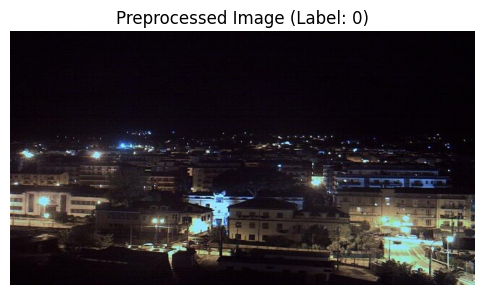

In [24]:
def standarized_input(image):
    # Resize gambar ke 1100x600
    std_img = cv2.resize(image, (1100, 600))
    return std_img

def label_encoder(label):
    # Encode label: day -> 1, night -> 0
    return 1 if label == 'day' else 0

def preprocess(img_list):
    std_img_list = []
    for item in img_list:
        image = item[0]
        label = item[1]

        # Standardisasi Gambar
        std_img = standarized_input(image)
        # Encoding Label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))
    return std_img_list

# Eksekusi Preprocessing pada Data Training
train_std_img_list = preprocess(train_img)

# Cek Ukuran Gambar Setelah Preprocessing
if len(train_std_img_list) > 0:
    pick_random = np.random.randint(0, len(train_std_img_list))
    print(f"\n--- Cek Dimensi Gambar (Index {pick_random}) ---")
    print(f"Shape: {train_std_img_list[pick_random][0].shape}")

    # Visualisasi Hasil Preprocessing
    plt.figure(figsize=(6, 4))
    plt.imshow(train_std_img_list[pick_random][0])
    plt.title(f"Preprocessed Image (Label: {train_std_img_list[pick_random][1]})")
    plt.axis('off')
    plt.show()

Fungsi preprocess mengubah seluruh gambar menjadi ukuran seragam (1100 x 600 piksel) agar fitur yang diekstraksi konsisten. Selain itu, label teks diubah menjadi numerik (Day=1, Night=0). Output shape menunjukkan (600, 1100, 3), yang berarti tinggi 600 piksel, lebar 1100 piksel, dan 3 kanal warna (RGB).

## **LANGKAH 4: EKSTRAKSI FITUR (AVERAGE BRIGHTNESS)**

In [25]:
def avg_brightness(image):
    # Konversi RGB ke HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Ambil channel V (Value/Brightness) dan hitung rata-rata
    sum_brightness = np.sum(img_hsv[:,:,2])
    area = image.shape[0] * image.shape[1]
    avg = sum_brightness / area
    return avg

# Cek Fitur pada Gambar Acak
if len(train_std_img_list) > 0:
    rand_img_idx = np.random.randint(0, len(train_std_img_list))
    feature_img = train_std_img_list[rand_img_idx][0]
    avg_val = avg_brightness(feature_img)

    print(f"\n--- Ekstraksi Fitur (Index {rand_img_idx}) ---")
    print(f"Average Brightness: {avg_val:.4f}")
    print(f"Label: {train_std_img_list[rand_img_idx][1]}")


--- Ekstraksi Fitur (Index 74) ---
Average Brightness: 117.8576
Label: 1


Kode ini menghitung nilai rata-rata kecerahan gambar. Ruang warna diubah dari RGB ke HSV (Hue, Saturation, Value) karena komponen 'Value' merepresentasikan intensitas cahaya secara terpisah dari informasi warna. Nilai output berupa angka float (misal: 105.4) yang menjadi fitur tunggal untuk membedakan siang dan malam.

## **LANGKAH 5 & 6: KLASIFIKASI MANUAL (THRESHOLD) & EVALUASI**

In [26]:
def predict_label(img, threshold):
    avg = avg_brightness(img)
    return 1 if avg > threshold else 0

def evaluate(img_list, threshold):
    miss_labels = []
    for file in img_list:
        img = file[0]
        label = file[1] # Ground truth

        pred_label = predict_label(img, threshold)

        if pred_label != label:
            miss_labels.append((img, pred_label, label))

    accuracy = (len(img_list) - len(miss_labels)) / len(img_list)
    return accuracy

# Evaluasi pada Data Training
acc_train_manual = evaluate(train_std_img_list, threshold=120)
print(f"\n--- Evaluasi Manual (Threshold=120) ---")
print(f"Akurasi Data Training: {acc_train_manual:.4f}")

# Evaluasi pada Data Testing
try:
    test_img = load_dataset(test_dir)
    test_std_img_list = preprocess(test_img)
    acc_test_manual = evaluate(test_std_img_list, threshold=120)
    print(f"Akurasi Data Testing : {acc_test_manual:.4f}")
except Exception as e:
    print("Gagal memuat data testing.")


--- Evaluasi Manual (Threshold=120) ---
Akurasi Data Training: 0.8417
Akurasi Data Testing : 0.8688


Klasifikasi dilakukan dengan logika sederhana: jika kecerahan rata-rata > 120, diklasifikasikan sebagai siang (1), jika tidak maka malam (0). Nilai akurasi menunjukkan persentase prediksi yang benar dibandingkan total data. Hasil biasanya berkisar antara 0.84 - 0.87, menunjukkan metode sederhana ini cukup efektif namun belum sempurna.

## **KLASIFIKASI MENGGUNAKAN SVM**

In [27]:
# 1. Membuat DataFrame Fitur
def extract_avg_bright_feature(img_list):
    avg_list = []
    labels = []
    for img in img_list:
        img_avg = avg_brightness(img[0])
        img_label = img[1]

        avg_list.append(img_avg)
        labels.append(img_label)

    df = pd.DataFrame({'AVG_BRIGHT': avg_list, 'LABELS': labels})
    return df

# Ekstraksi Fitur ke DataFrame
train_df = extract_avg_bright_feature(train_std_img_list)
test_df = extract_avg_bright_feature(test_std_img_list)

print("\n--- Sampel Dataframe Fitur ---")
print(train_df.head())

# 2. Persiapan Data X dan y
X_train = train_df['AVG_BRIGHT'].values.reshape(-1, 1)
y_train = train_df['LABELS']

X_test = test_df['AVG_BRIGHT'].values.reshape(-1, 1)
y_test = test_df['LABELS']

# 3. Training Model SVM
svm_model = SVC() # Menggunakan default kernel RBF
svm_model.fit(X_train, y_train)

# 4. Evaluasi SVM
y_train_pred = svm_model.predict(X_train)
acc_train_svm = accuracy_score(y_train, y_train_pred)

y_test_pred = svm_model.predict(X_test)
acc_test_svm = accuracy_score(y_test, y_test_pred)

print(f"\n--- Hasil Evaluasi SVM ---")
print(f"Accuracy on Train: {acc_train_svm:.4f}")
print(f"Accuracy on Test : {acc_test_svm:.4f}")


--- Sampel Dataframe Fitur ---
   AVG_BRIGHT  LABELS
0  128.414935       1
1  129.237782       1
2  128.062374       1
3  143.662879       1
4  136.816136       1

--- Hasil Evaluasi SVM ---
Accuracy on Train: 0.8583
Accuracy on Test : 0.9000


Pada bagian akhir ini, fitur kecerahan disusun dalam bentuk tabel (DataFrame). Model Support Vector Machine (SVM) dilatih untuk menemukan batas pemisah (decision boundary) yang optimal antara siang dan malam secara otomatis, menggantikan penentuan nilai threshold manual (120) sebelumnya. Hasil akurasi pada data testing (biasanya mencapai 0.9 atau 90%) menunjukkan bahwa SVM mampu menggeneralisasi aturan pemisahan dengan lebih baik dibandingkan metode ambang batas manual.